In [ ]:
#%%

import torch
import torch.nn as nn
from torch.nn import functional as F
import numpy as np
from matplotlib import pyplot as plt
from collections import defaultdict
import seaborn as sns # type: ignore

torch.manual_seed(42) 

#input dimension
D = 4
#matrix dimension
N = 2000
#batch dimension
B = 64
#number of data points
P = 4000

Our ground truth will be a quadratic model of input dimension $D$ with fixed weights of the form $ Y = (W \cdot X)^2 $ where W is a $1 \times D$ matrix.

In [ ]:
# %%

"""
We are going to make a quadratic model which we will train with an MLP in the lazy limit.
"""
#Generate quadratic data
Xraw = torch.randn((P, D))
Wmap = torch.randn((D, 1))/np.sqrt(D)
Yraw = (Xraw@Wmap)**2
Yraw.shape

torch.Size([4000, 1])

In [ ]:
#%%

def MLP(params, x, gamma):
    for param in params[:-1]: 
        x = x @ param  /(np.sqrt(x.shape[-1]))
        x = nn.ReLU()(x)

    return x@params[-1] /(gamma*np.sqrt(x.shape[-1]))

We can train a single layer MLP of the form:
\begin{align*}
f(X) = \frac{1}{\gamma}\times \frac{1}{\sqrt{N}} W^{(1)}\cdot  \phi\left(\frac{1}{\sqrt{D}}  W^{(0)} \cdot X\right )
\end{align*}

with $W^{(0)}$ an $N \times D$ matrix, $W^{(1)}$ a $1 \times N$ matrix, $\phi$ the ReLU activation, and $\gamma$ a downscaling parameter whose implication we will explore.

In [ ]:
# %%

"""
Let's make an input and an output can confirm that we can train on the above
"""
loss_dict = defaultdict(list)


for gamma in [1,  1e-1, 1e-3, 1e-5]:
    params = [ torch.randn((i, j), requires_grad=True) for i, j in [(D, N),  (N, 1)] ]
    params0 = [torch.clone(param.detach()) for param in params]


    fwd_fn = lambda params, Xin, gamma : MLP(params, Xin, gamma)-MLP(params0, Xin, gamma)
    loss_fn = lambda params, Xin, gamma, Yout : (fwd_fn(params, Xin, gamma)-Yout).transpose(0, 1) @(fwd_fn(params, Xin, gamma)-Yout) / Yout.shape[0]

    eta = 2*gamma**2


    optimizer = torch.optim.SGD(params, lr=eta)
    optimizer.zero_grad()
    loss = loss_fn(params, Xraw[0:B], gamma, Yraw[0:B])
    loss.backward()
    optimizer.step()

    
    loss_dict[gamma] = []
    for t in range(P//B):
        optimizer.zero_grad()
        loss = loss_fn(params, Xraw[t*B:(t+1)*B], 1, Yraw[t*B:(t+1)*B])
        loss.backward()
        optimizer.step()
        loss_dict[gamma].append(loss.item())

In [ ]:
 #%%

 #Now the explicitly linearized model 
params = [ torch.randn((i, j), requires_grad=True) for i, j in [(D, N),  (N, 1)] ]
params0 = [torch.clone(param.detach()) for param in params]    

def linear_approx(params, params0, Xin, gamma):
    def f(params):
        return fwd_fn(params, Xin, gamma)
    
    v = [p - p0 for p, p0 in zip(params, params0)]
    _, jvp = torch.func.jvp(f, (params,), (v,))
    return jvp


loss_dict[0] = []
# Example usage of linear approximation
for t in range(P//B):
    jvp_result = linear_approx(params, params0, Xraw[t*B:(t+1)*B], 1)
    loss = (jvp_result - Yraw[t*B:(t+1)*B]).transpose(0, 1) @ (jvp_result - Yraw[t*B:(t+1)*B]) / Yraw[t*B:(t+1)*B].shape[0]
    loss_dict[0].append(loss.item())

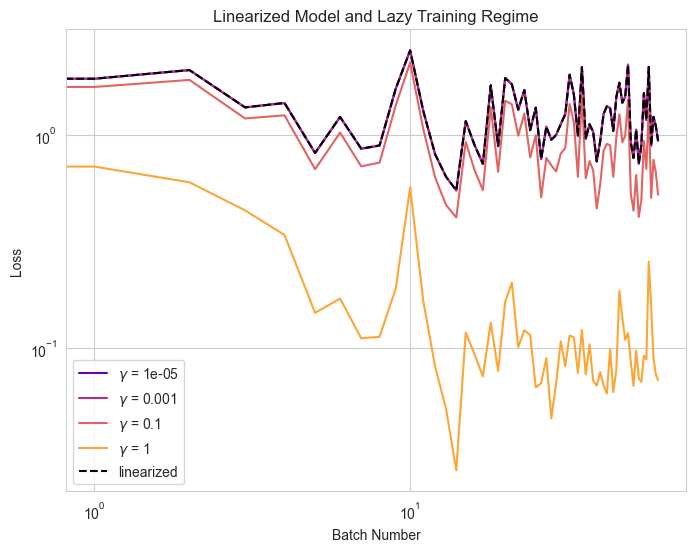

In [ ]:
# %%

sns.set_style("whitegrid")
sns.set_palette("plasma", len(loss_dict)-1)
plt.figure(figsize=(8, 6))


for gamma in [1e-05, 0.001, 0.1, 1]:
    plt.plot([t for t in range(P//B)] , loss_dict[gamma], alpha=1.0, label=f"$\gamma$ = {gamma}")
    plt.xscale('log')
    plt.yscale('log')

plt.plot([t for t in range(P//B)] , loss_dict[0], 'k--', alpha = 1.0, label = "linearized")
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.title('Linearized Model and Lazy Training Regime')
plt.xlabel('Batch Number')
plt.ylabel('Loss')

plt.show()

In [ ]:
# %%

"""
So far we have seen that on the quadratic task, the lazy training regime (small gamma)
is equivalent to using the linearization of the model. 
Next we will explore the Neutral Tangent Kernel (NTK), which is a good approximation at large width, where the weights naturally
become lazy.
So we want to train the linearized model and see how it compares to the wide MLP.
"""

'\nSo far we have seen that on the quadratic task, the lazy training regime (small gamma)\nis equivalent to using the linearization of the model. \nNext we will explore the Neutral Tangent Kernel (NTK), which is a good approximation at large width, where the weights naturally\nbecome lazy.\nSo we want to train the linearized model and see how it compares to the wide MLP.\n'

In [ ]:
#%%

params = [ torch.randn((i, j), requires_grad=True) for i, j in [(D, N), (N, 1)] ]
params0 = [torch.clone(param.detach()) for param in params]

gamma = 1
N = 5000

fwd_fn = lambda params, Xin, gamma : MLP(params, Xin, gamma)-MLP(params0, Xin, gamma)

def linear_approx(params, params0, Xin, gamma):
    def f(params):
        return fwd_fn(params, Xin, gamma)
    
    v = [p - p0 for p, p0 in zip(params, params0)]
    _, jvp = torch.func.jvp(f, (params0,), (v,))
    return jvp



linear_fwd = lambda params, Xin, gamma : linear_approx(params, params0, Xin, gamma)
linear_loss = lambda params, Xin, gamma, Yout : (linear_approx(params, params0, Xin, gamma)-Yout).transpose(0, 1) @(linear_approx(params, params0, Xin, gamma)-Yout) / Yout.shape[0]


eta = 2*gamma**2


optimizer = torch.optim.SGD(params, lr=eta)



loss_dict["linearized"] = []
for t in range(0, P//B):
    optimizer.zero_grad()
    loss = linear_loss(params, Xraw[t*B:(t+1)*B], gamma, Yraw[t*B:(t+1)*B])
    loss.backward()
    optimizer.step()
    loss_dict["linearized"].append(loss.item())

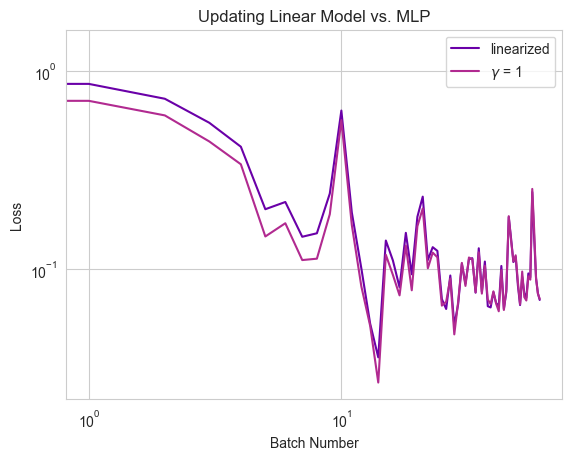

In [ ]:
# %%

plt.plot([t for t in range(P//B)] , loss_dict["linearized"], alpha = 1.0, label = "linearized")
plt.plot([t for t in range(P//B)] , loss_dict[1], alpha = 1.0, label = "$\gamma$ = 1")
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.title('Updating Linear Model vs. MLP')
plt.xlabel('Batch Number')
plt.ylabel('Loss')
plt.show()

In [ ]:
# %%

"""
Computing the Neural Tangent Kernel
"""

def compute_ntk(fwd_fn, params, Xin, gamma):
    # Compute the Jacobian of the model's output with respect to its parameters
    def jacobian(fwd_fn, params, Xin, gamma):
        output = fwd_fn(params, Xin, gamma)
        jacobian = []
        for out in output:
            grad_params = torch.autograd.grad(out, params, retain_graph=True, create_graph=True)
            jacobian.append(torch.cat([g.view(-1) for g in grad_params]))
        return torch.stack(jacobian)

    # Compute the Jacobians for both input sets
    J = jacobian(fwd_fn, params, Xin, gamma)
    

    # Compute the NTK as the Gram matrix of the Jacobians
    NTK = J @ J.transpose(0, 1)
    return NTK

# Example usage
params = [torch.randn((i, j), requires_grad=True) for i, j in [(D, N), (N, 1)]]
params0 = [torch.clone(param.detach()) for param in params]
gamma = 1

fwd_fn = lambda params, Xin, gamma : MLP(params, Xin, gamma) - MLP(params0, Xin, gamma)

ntk = compute_ntk(fwd_fn, params, Xraw, 1)
spec = np.linalg.eigvalsh(np.array(ntk.detach()))

ntk_spec_dict = defaultdict(list)
ntk_spec_dict["empiric"] = sorted(spec)[::-1]

In [ ]:
# %%

def relu_ntk(X1, X2):
    """
    Compute the NTK for a single hidden layer with ReLU activation in the infinite width limit.
    X1: torch.Tensor of shape (n1, d)
    X2: torch.Tensor of shape (n2, d)
    Returns: torch.Tensor of shape (n1, n2)
    """
    X1 = X1 / torch.norm(X1, dim=1, keepdim=True)
    X2 = X2 / torch.norm(X2, dim=1, keepdim=True)
    
    dot_product = X1 @ X2.T
    # Clip the dot product to the range [-1, 1] to avoid NaNs in arccos
    dot_product = torch.clamp(dot_product, -1.0, 1.0)
    theta = torch.acos(dot_product)
    
    ntk = (torch.sin(theta) + (np.pi - theta) * torch.cos(theta)) / np.pi
    return ntk

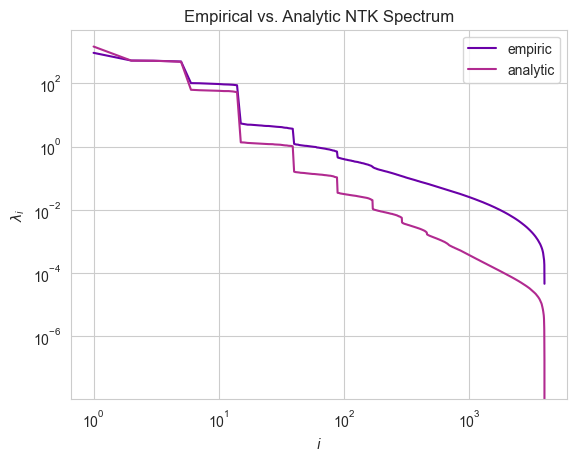

In [ ]:
#%%

# Plot the eigenvalues of the NTK matrix
ntk  = relu_ntk(Xraw, Xraw)
spec = np.linalg.eigvalsh(np.array(ntk.detach()))
ntk_spec_dict["analytic"] = sorted(spec)[::-1]

plt.plot([x for x in range(1, len(spec)+1)], ntk_spec_dict["empiric"], label = "empiric")
plt.plot([x for x in range(1, len(spec)+1)], ntk_spec_dict["analytic"], label = "analytic")
plt.xscale('log')
plt.yscale('log')
plt.title('Empirical vs. Analytic NTK Spectrum')
plt.xlabel('$i$')
plt.ylabel('$\lambda_i$')
plt.legend()
plt.show()

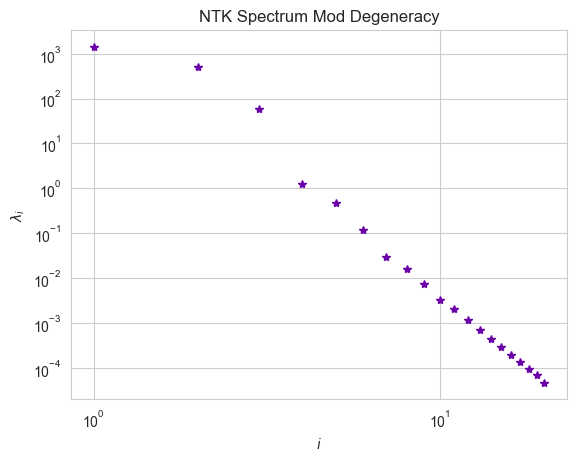

In [ ]:
#%%

#Look at degeneracy
maxk = 20

degen_ct = [(1+k)**2 for k in range(0, maxk)]
ntk_avg = []
for i in range(0, maxk):
    st_idx = sum(degen_ct[0:i] )
    e_idx = st_idx+degen_ct[i]
    ntk_avg.append( np.mean( ntk_spec_dict["analytic"][st_idx:e_idx]  ) )

plt.plot([x for x in range(1, maxk+1)], ntk_avg, "*")
plt.xscale('log')
plt.yscale('log')
plt.title('NTK Spectrum Mod Degeneracy')
plt.xlabel('$i$')
plt.ylabel('$\lambda_i$')

plt.show()

In [ ]:
#%%

def gp_loss(X, Xst, Y, Yst):
    # Ensure all tensors are in float64 precision
    X = X.double()
    Xst = Xst.double()
    Y = Y.double()
    Yst = Yst.double()

    KXX = relu_ntk(X, X) + 1e-5 * torch.eye(X.shape[0], dtype=torch.float64)
    KXXst = relu_ntk(X, Xst)
    KXstX = KXXst.T
    KXstXst = relu_ntk(Xst, Xst)

    GP_mean = (KXstX @ torch.linalg.inv(KXX)) @ Y
    GP_cov = KXstXst - (KXstX @ torch.linalg.inv(KXX) @ KXXst)
    L = torch.linalg.cholesky(GP_cov)
    fst_dist = torch.distributions.MultivariateNormal(GP_mean, scale_tril=L)
    pred = fst_dist.sample()

    return ((pred - Yst) ** 2).mean()

In [ ]:
# %%

loss_dict["NTK"] = []
for t in range(1, P // B):
    loss = gp_loss(Xraw[0:t * B].double(), Xraw[t * B:(t + 1) * B].double(), Yraw[0:t * B].view(t * B).double(), Yraw[t * B:(t + 1) * B].view(B).double())
    loss_dict["NTK"].append(loss.item())

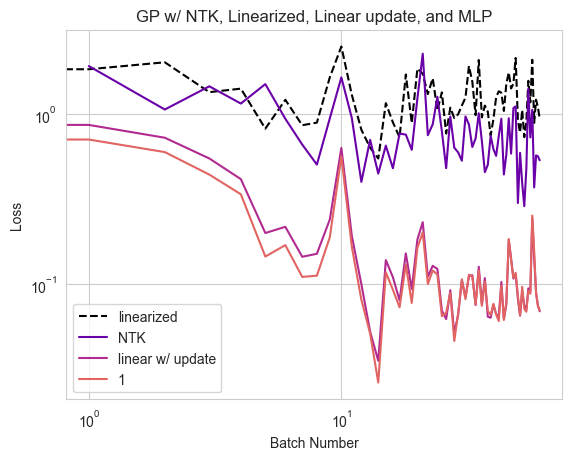

In [ ]:
# %%

plt.plot([t for t in range(P//B)] , loss_dict[0], "k--", alpha = 1.0, label = "linearized")
plt.plot([t for t in range(1, P//B)] , loss_dict["NTK"], alpha = 1.0, label = "NTK")
plt.plot([t for t in range(P//B)] , loss_dict["linearized"], alpha = 1.0, label = "linear w/ update")
plt.plot([t for t in range(P//B)] , loss_dict[1], alpha = 1.0, label = "1")
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.title('GP w/ NTK, Linearized, Linear update, and MLP')
plt.xlabel('Batch Number')
plt.ylabel('Loss')
plt.show()